## Time series

There are several ways to model Time Series in pyMC3


## Poison process example


### Import libraries 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm 
import pandas as pd
from theano.printing import pydotprint

import seaborn as sns 
import os
import sys

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import our own library functions

In [2]:
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
os.chdir("../../")
base_path = os.path.abspath('')
sys.path.append(base_path + "/")
import import_folders


Base path: /home/montoya/Desktop/bolsa/Trapyng/Code


In [3]:
# Own graphical library
from graph_lib import gl
import utilities_lib as ul

import HBM_plotting as HBMpl

### Own options and configurations

In [4]:
folder_images = "../pics/HBM/time_series_1/"
data_path = "../data/data_HBM/txtdata.csv"
ul.create_folder_if_needed(folder_images)

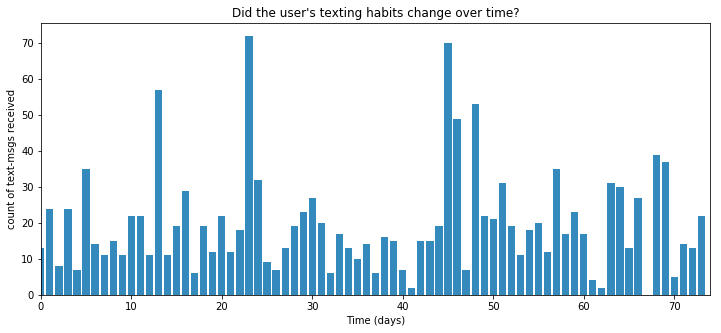

In [5]:

count_data = np.loadtxt(data_path)
n_count_data = len(count_data)

# Get the axes
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111, xlabel='Time (days)', ylabel='count of text-msgs received', title="Did the user's texting habits change over time?")

plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlim(0, n_count_data);

We model it with a **Poisson process**, meaning, every marginal day follows a Denoting day $i$'s text-message count by $C_i$, 

$$ C_i \sim \text{Poisson}(\lambda_i)  $$

We need to estimate the mean $\lambda_i$ at any point in time. To do so we would have the two extreme cases:

* Same lambda for each time $t$: $\lambda_i$ = $\lambda$. We would just compute the ML estimator of $\lambda$ using all the samples.
* Different lambda for each time $t$: $\lambda_i \neq \lambda_j$, $\forall i \neq j$. 

The actual distribution is somewhere in the middle. We need somehow to merge the information of sll to identify possible different regimes. 


The $\lambda_i$ seems to be higher in the second half than in the first for example.
Would you say there was a change in behaviour during this time period? We are going to try to model it. Two approaches:

* [1] There is a unique change point
* [2] The same but we force
* [2] There is some parameter about the distribution of days that changes smoothly with time.


## [1] Single change in lambda

Assumption: All parameters $\lambda_i$ are equal to some value $\lambda_1$ at the beggining. At some day, namely $t = \tau$,  all the parameters change to $\lambda_2$. So we really have two $\lambda$ parameters: one for the period before $\tau$, and one for the rest of the observation period. In the literature, a sudden transition like this would be called a *switchpoint*:

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$


We are interested in inferring the unknown $\lambda$s. If in reality, no sudden change occurred and indeed $\lambda_1 = \lambda_2$, then the $\lambda$s posterior distributions should look about equal.


## Priors 

The **priors for the $\lambda$s** will follow an Exponential distribution with same hyperparameter $\alpha$.

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha )
\end{align}

Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the expected value identity shown earlier to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

An alternative, and something I encourage the reader to try, would be to have two priors: one for each $\lambda_i$. Creating two exponential distributions with different $\alpha$ values reflects our prior belief that the rate changed at some point during the observations.

The **prior of $\tau$** will come from a Uniform distribution over the possibility space, given that it hard to pick one area.

\begin{align}
& \tau \sim \text{DiscreteUniform(1,70) }\\\\
& \Rightarrow P( \tau = k ) = \frac{1}{70}
\end{align}


In [6]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:

    idx = np.arange(n_count_data) # Index
        
    ## Hyper parameters
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    prior_tau =  n_count_data - 1
    
    ## Priors from hyperparameters
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    tau = pm.DiscreteUniform("tau", lower=0, upper=prior_tau)
    
    ## Switchpoint logic
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    ## Observation !
    observation = pm.Poisson("obs", lambda_, observed=count_data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:08<00:00, 7489.71draws/s]
The number of effective samples is smaller than 25% for some parameters.


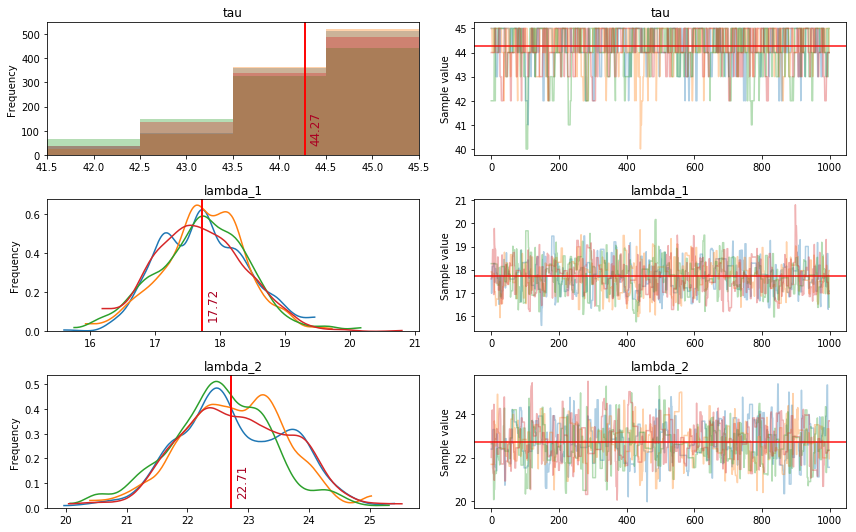

In [7]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

HBMpl.plot_traces(trace)

In [23]:
def trace_to_pd(trace):
    df = pd.DataFrame()
    for varname in trace.varnames:
        if(varname[-1] != "_"):
            df[varname] = trace[varname]
    return df

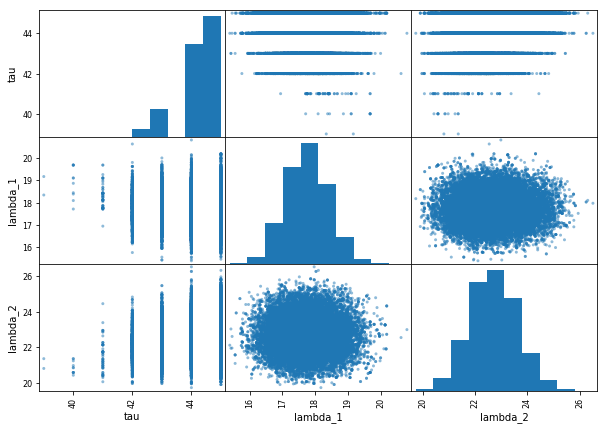

In [25]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111)

axes = pd.plotting.scatter_matrix(trace_to_pd(trace),ax = ax1)
fig.savefig(folder_images +'variables_analysis.png', dpi = 100) ## Variables

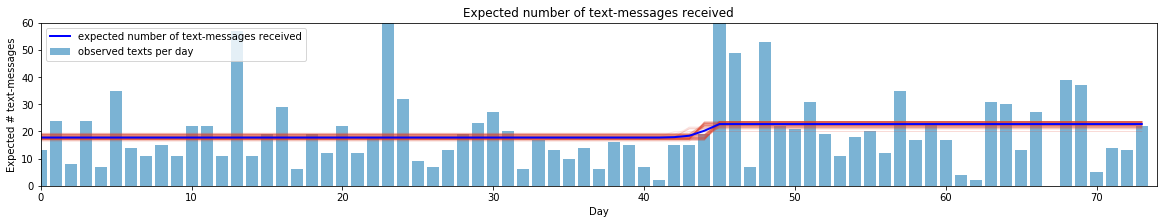

In [8]:
HBMpl.plot_lambda_func(trace,count_data )

## [2] Impossing one of the 2 lambdas to be the bigger

What if we want to impose that $\lambda_1 > \lambda_2$ or viceverse? There are different possibilities:

* Forcing another switch where drawn value of lambda_1 go to lambda_min and viceversa: Wrong !! it creates bimodal oscillations !
* The second lambda is equal to the first plus some value:
    $$ 
    \lambda_2 = \lambda_1 + \delta
    $$
   Where $\delta$ comes from a non-negative distribution of values, usually a half Gaussian or Laplacian:
   $$
   \delta \sim \mathcal{L}()
   $$

 The problem is that the noise of the differences will grow with time now.

### Oscillation bad one:

In [55]:
with pm.Model() as model:

    idx = np.arange(n_count_data) # Index
        
    ## Hyper parameters
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    prior_tau =  n_count_data - 1
    
    ## Priors from hyperparameters
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=prior_tau)
    
    ## Switchpoint logic
    
    lambda_max = pm.math.switch(lambda_1 > lambda_2, lambda_1, lambda_2)
    lambda_min = pm.math.switch(lambda_1 < lambda_2, lambda_1, lambda_2)
    
    # If time is lower than tau, we use lambda min, so this shit increases !!
    lambda_ = pm.math.switch(tau > idx, lambda_min, lambda_max)
    
    ## Observation !
    observation = pm.Poisson("obs", lambda_, observed=count_data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:24<00:00, 2477.21draws/s]
The acceptance probability does not match the target. It is 0.9010115817844546, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.599208137415099, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


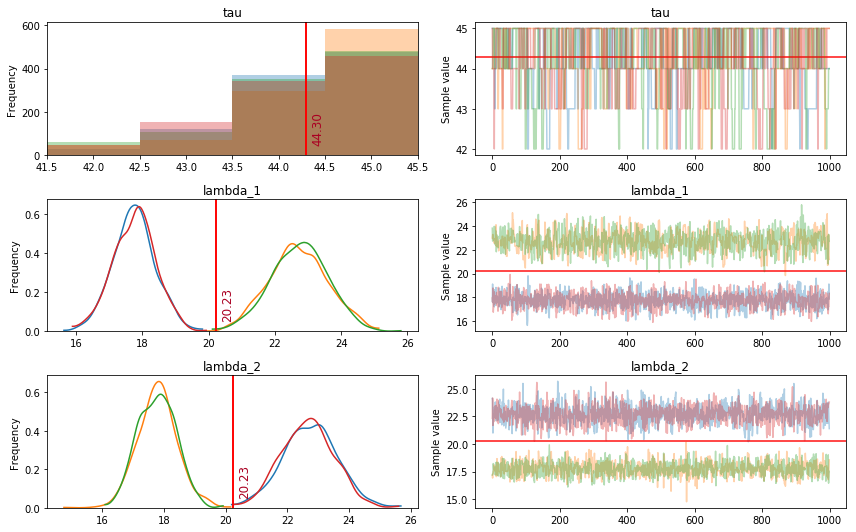

In [59]:
with model:
# From memory, NUTS assumes continuity (and differentiability?) of likelihood function: 
#a breakpoint introduces a discontinuity and hence Metropolis works but NUTS does not
    step1 = pm.NUTS([lambda_1, lambda_2])
    step2 = pm.Metropolis([tau])
    
    trace = pm.sample(10000, tune=5000,step=[step1,step2])

HBMpl.plot_traces(trace)

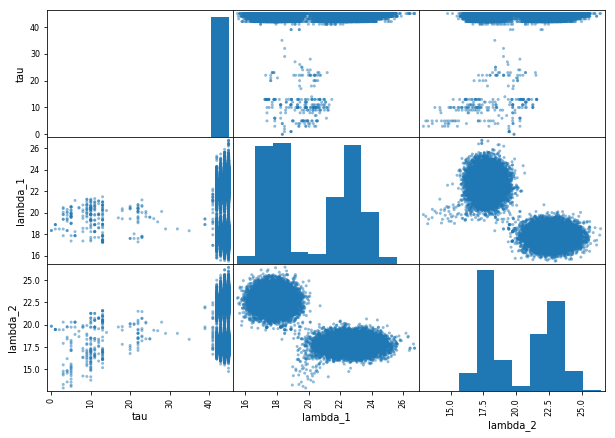

In [60]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111)

axes = pd.plotting.scatter_matrix(trace_to_pd(trace),ax = ax1)
fig.savefig(folder_images +'variables_analysis.png', dpi = 100) ## Variables

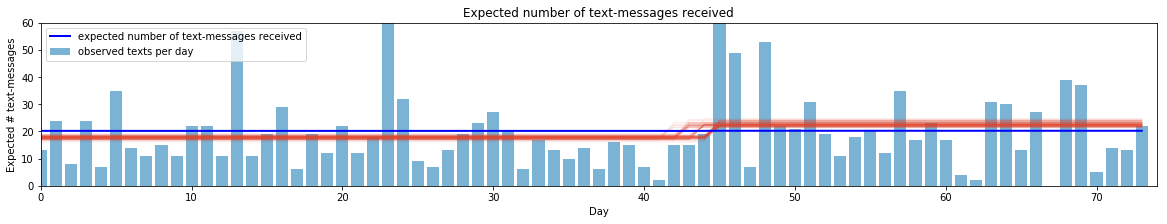

In [61]:
HBMpl.plot_lambda_func(trace,count_data )

## [2] Using differences

In [50]:
## Only one turnpoint !!
with pm.Model() as model:

    idx = np.arange(n_count_data) # Index
        
    ## Hyper parameters
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    prior_tau =  n_count_data - 1
    
    ## Priors from hyperparameters
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_12_diff = pm.HalfNormal("lambda_12_diff", sd = 10)# pm.Exponential("lambda_12_diff", 1)
    lambda_2 = pm.Deterministic('lambda_2',lambda_1 - lambda_12_diff)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=prior_tau)
    
    # If time is lower than tau, we use lambda min, so this shit increases !!
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    ## Observation !
    observation = pm.Poisson("obs", lambda_, observed=count_data)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_12_diff]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:13<00:00, 4384.25draws/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


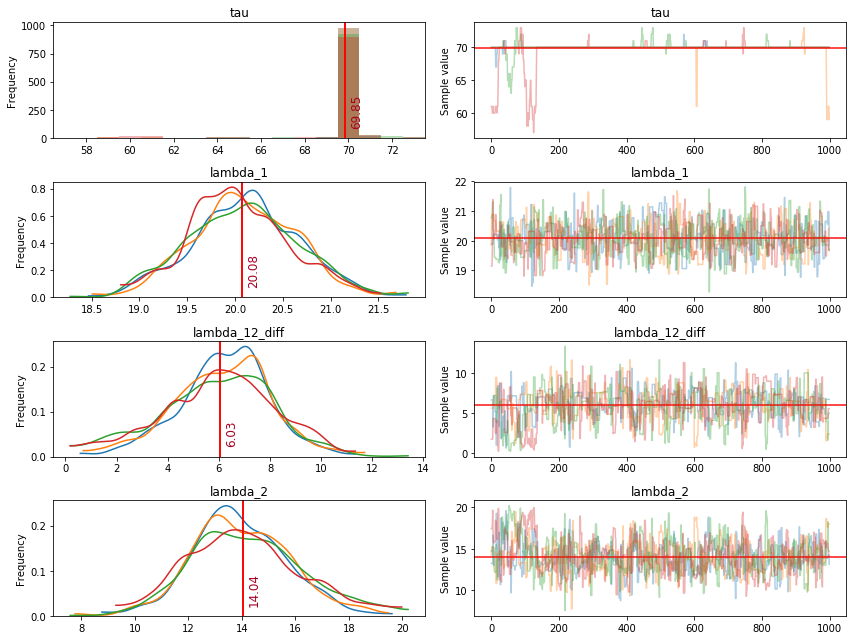

In [51]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

HBMpl.plot_traces(trace)

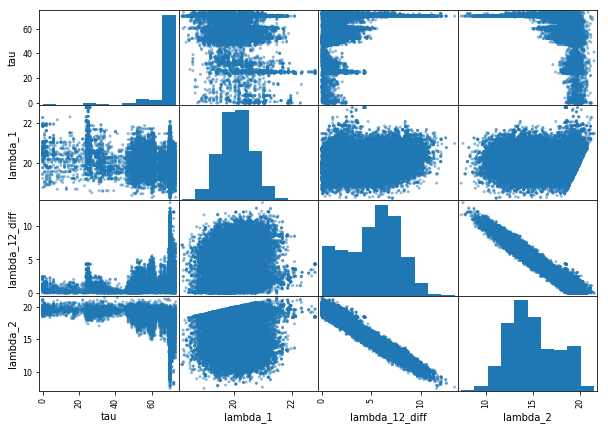

In [53]:
fig = plt.figure(figsize=(10, 7))
ax1 = fig.add_subplot(111)

axes = pd.plotting.scatter_matrix(trace_to_pd(trace),ax = ax1)
fig.savefig(folder_images +'variables_analysis.png', dpi = 100) ## Variables

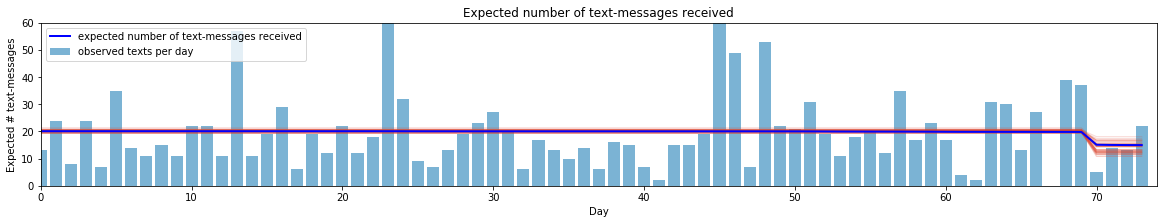

In [54]:
HBMpl.plot_lambda_func(trace,count_data )

## Time varying parameters
you can allow the coefficients in the model change over time

First, the data is viewed as the result of a data generating process, the non-stationary nature of the data is a consequence of the evolving model, not an inherent feature in the data. Second, the model is going to be very flexible and likely to fit the data very well.

In this case we are saying that the $\lambda_i$ belongs to a Geometric noise process. The random walk process has length equal to the training data.

$$\lambda \sim RandomWalk(\sigma_{RW}, N) $$


This means that each $\lambda _i$ comes from a guassian distribution with mean, $\lambda_{i-1}$, and variance $\sigma_{RW}$:

$$
\lambda_{i} \sim \mathcal{N}(\lambda_{i-1},   \sigma_{RW})
$$


In [108]:
with pm.Model() as model:

    idx = np.arange(n_count_data) # Index
        
    ## Hyper parameters
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    sigma = pm.HalfCauchy('sigma', beta=10, testval=1.)
    
    ## Priors from hyperparameters
    lambda_i_log = pm.GaussianRandomWalk('s', sd=sigma, shape=n_count_data, mu = count_data[0])
    
    lambda_i =  pm.Deterministic('lambda_i', pm.math.exp(lambda_i_log))
    ## Observation !
    observation = pm.Poisson("obs", lambda_i, observed=count_data)

In [109]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(1000, tune=5000,step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [s]
>Metropolis: [sigma]
Sampling 4 chains: 100%|██████████| 24000/24000 [00:02<00:00, 8217.67draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


[[2.68264043 3.35266652 2.18612738 ... 2.31006111 2.83307016 3.28823131]
 [2.68264043 3.35266652 2.18612738 ... 2.31006111 2.83307016 3.28823131]
 [2.68264043 3.35266652 2.18612738 ... 2.31006111 2.83307016 3.28823131]
 ...
 [2.77701748 3.29379114 2.70708689 ... 2.33647167 2.60848068 2.63316178]
 [2.77701748 3.29379114 2.70708689 ... 2.33647167 2.60848068 2.63316178]
 [2.76807637 3.27785572 2.68984732 ... 2.33716764 2.5942222  2.65749891]]


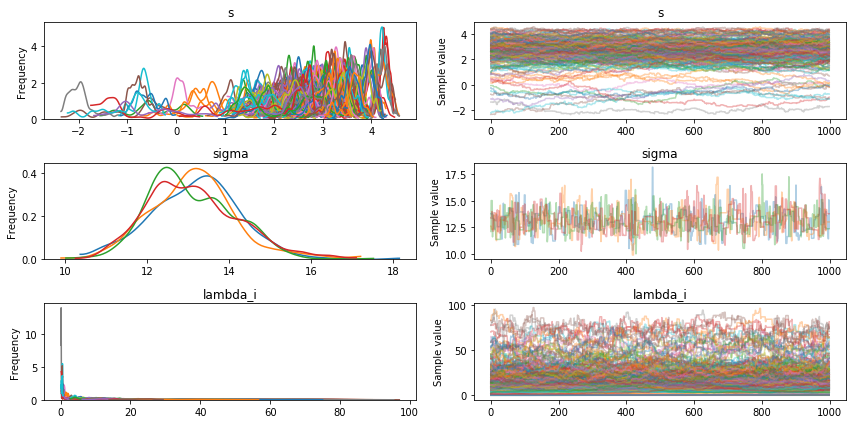

In [110]:
pm.traceplot(trace)
print(trace["s"])

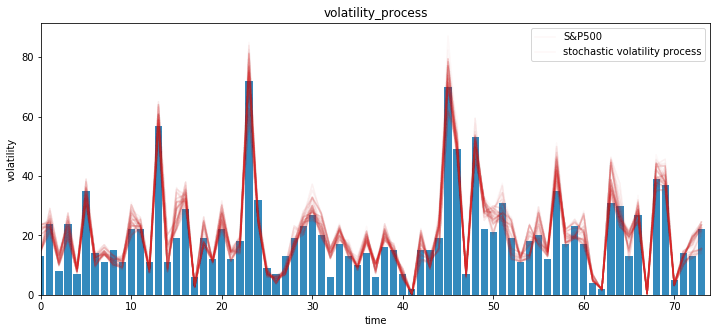

In [111]:
# Get the axes
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(111, xlabel='Time (days)', ylabel='count of text-msgs received', title="Did the user's texting habits change over time?")

plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlim(0, n_count_data);

ax1.plot(np.arange(n_count_data), trace['lambda_i'][-100:,:].T, 'C3', alpha=.03);
ax1.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax1.legend(['S&P500', 'stochastic volatility process']);


In [112]:
trace['s'].shape

(4000, 74)

## Piecewise multiple points 

It seems not possible without the breakpoints !!

We usually estimate the breakpoints as the loss function is very easy to compute one we have them. 



In [100]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)


In [103]:
## Several Laplacian turnpoints !!

# Turnpoints !!
n_changepoints = 3

## Time index
idx_t = np.arange(n_count_data) # Index

## Change_points
s = np.linspace(0, n_count_data, n_changepoints + 1)[1:]
s = np.floor(s)
A = (idx_t[:, None] > s) * 1

print(s)
#print (A)

[24. 49. 74.]


In [104]:
class Ordered(pm.distributions.transforms.ElemwiseTransform):
    name = "ordered"

    def forward(self, x):
        out = tt.zeros(x.shape)
        out = tt.inc_subtensor(out[0], x[0])
        out = tt.inc_subtensor(out[1:], tt.log(x[1:] - x[:-1]))
        return out
    
    def forward_val(self, x, point=None):
        x, = pm.distributions.distribution.draw_values([x], point=point)
        return self.forward(x)

    def backward(self, y):
        out = tt.zeros(y.shape)
        out = tt.inc_subtensor(out[0], y[0])
        out = tt.inc_subtensor(out[1:], tt.exp(y[1:]))
        return tt.cumsum(out)

    def jacobian_det(self, y):
        return tt.sum(y[1:])

In [105]:
changepoints_prior_scale = 3
with pm.Model() as model:

    ## Hyper parameters
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    prior_tau =  n_count_data - 1
    
    ## Priors from hyperparameters
    
    ## Initial lambda
    lambda_1 = pm.Exponential("lambda_1", alpha)
    # Differences in the lambdas:
    # The changes follow a laplacian distribution with mean 0 and variance the same for all changes
    # Use hyrarchical for that as well maybe
    
    if changepoints_prior_scale is None:
        # Herarchical prior on the variance of the Laplacian of the changes
        changepoints_prior_scale = pm.Exponential('tau', 1.5)
    
    lambda_diffs = pm.Laplace('lambda_diffs', 0, changepoints_prior_scale, shape=n_changepoints,
                             transform = Ordered())
    
    taus = pm.DiscreteUniform("tau", lower=0, upper=prior_tau, shape = n_changepoints, 
                              transform = Ordered())
    lambda_ = 
    
    ## Observation !
    observation = pm.Poisson("obs", lambda_, observed=count_data)

IndexError: too many indices for array

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_12_diff]
>Metropolis: [lambda_1]
Sampling 4 chains: 100%|██████████| 60000/60000 [00:12<00:00, 4625.01draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


This code creates a new function `lambda_`, but really we can think of it as a random variable: the random variable $\lambda$ from above. The `switch()` function assigns `lambda_1` or `lambda_2` as the value of `lambda_`, depending on what side of `tau` we are on. The values of `lambda_` up until `tau` are `lambda_1` and the values afterwards are `lambda_2`.

Note that because `lambda_1`, `lambda_2` and `tau` are random, `lambda_` will be random. We are **not** fixing any variables yet.

In [87]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

/home/montoya/anaconda3/envs/python36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


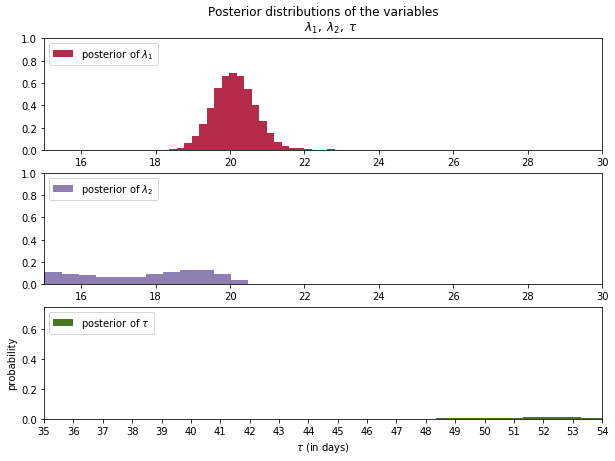

In [88]:

#histogram of the samples:
fig = plt.figure(figsize=(10, 7))
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

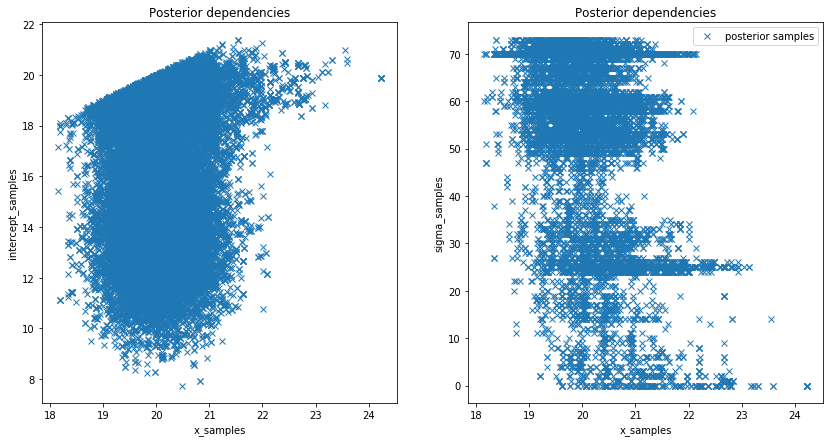

In [89]:
fig = plt.figure(figsize=(14, 7))

ax = fig.add_subplot(121, xlabel='x_samples', ylabel='intercept_samples', title='Posterior dependencies')
ax.plot(lambda_1_samples, lambda_2_samples, 'x', label='posterior samples')

ax = fig.add_subplot(122, xlabel='x_samples', ylabel='sigma_samples', title='Posterior dependencies')
ax.plot(lambda_1_samples, tau_samples, 'x', label='posterior samples')

plt.legend(loc=0);


# Regression 

In [113]:
returns = pd.read_csv(pm.get_data('SP500.csv'), parse_dates=True, index_col=0)

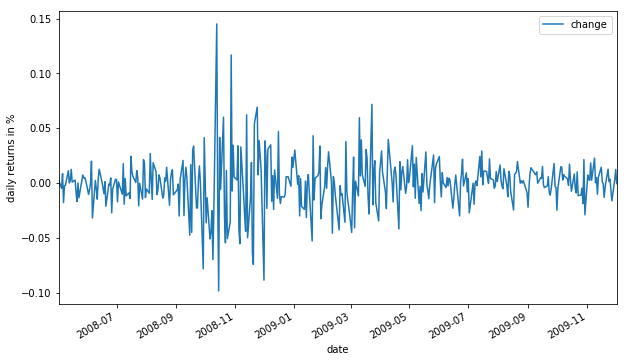

In [114]:
returns.plot(figsize=(10, 6))
plt.ylabel('daily returns in %');

In [115]:
with pm.Model() as sp500_model:
    nu = pm.Exponential('nu', 1/10., testval=5.)
    sigma = pm.Exponential('sigma', 1/0.02, testval=.1)

    s = pm.GaussianRandomWalk('s', sd=sigma, shape=len(returns))
    volatility_process = pm.Deterministic('volatility_process', pm.math.exp(-2*s)**0.5)

    r = pm.StudentT('r', nu=nu, sd=volatility_process, observed=returns['change'])

In [116]:
with sp500_model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, sigma, nu]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:37<00:00, 24.51draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


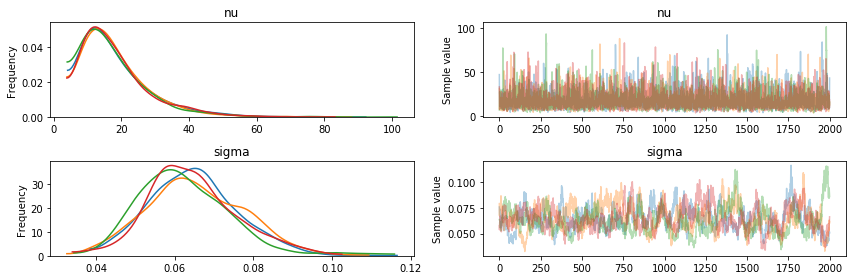

In [117]:
pm.traceplot(trace, varnames=['nu', 'sigma']);

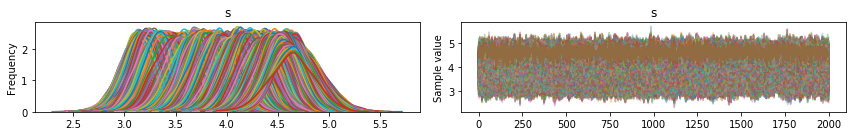

In [119]:
pm.traceplot(trace, varnames=['s']);

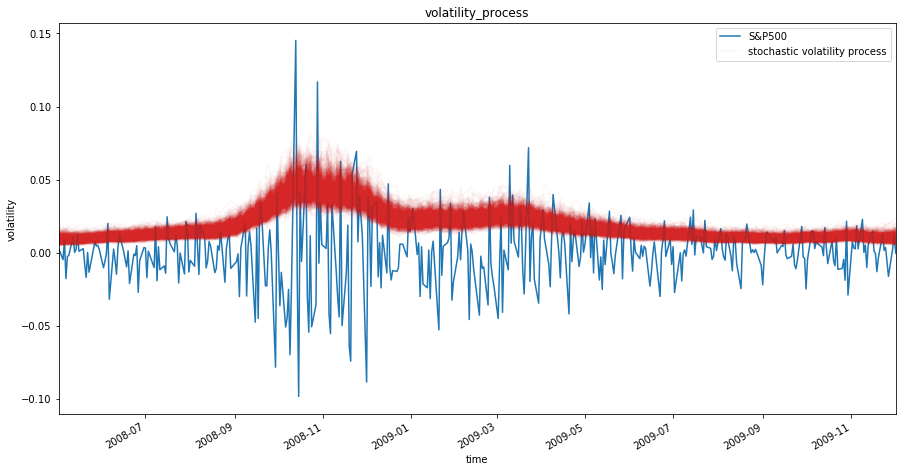

In [118]:
fig, ax = plt.subplots(figsize=(15, 8))
returns.plot(ax=ax)
ax.plot(returns.index, 1/np.exp(trace['s',::5].T), 'C3', alpha=.03);
ax.set(title='volatility_process', xlabel='time', ylabel='volatility');
ax.legend(['S&P500', 'stochastic volatility process']);